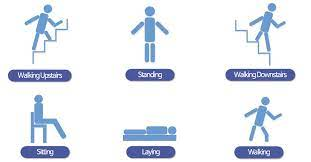

이번 시간에는 UCI 머신러닝 리포지토리에서 제공하는 사용자 행동 인식 데이터 세트에 대한 예측 분류를 수행합니다.

해당 데이터는 30명에게 스마트폰 센서를 장착한 뒤 사람의 동작과 관련된 여러가지 피처를 수집한 데이터입니다.

수집된 데이터를 기반으로 결정트리를 생성하고 어떠한 동작인지 예측해 봅시다.

http://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones

위 링크에서 UCI HAR Dataset.zip을 로드합니다.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# feature.txt 파일에는 피처 이름 index와 피처명이 공백으로 분리
feature_name_df = pd.read_csv('../data/HumanActivity/features.txt', sep='\s+', header=None, names=['column_index', 'column_name'])
feature_name_df.head()

,column_index,column_name
0,1,tBodyAcc-mean()-X
1,2,tBodyAcc-mean()-Y
2,3,tBodyAcc-mean()-Z
3,4,tBodyAcc-std()-X
4,5,tBodyAcc-std()-Y


In [3]:
# 피처명 index를 제거하고 피처명만 리스트 객체로 생성한 귀 샘플로 10개만 추출

feature_name = feature_name_df.iloc[:, 1].values.tolist()
feature_name[:10]

['tBodyAcc-mean()-X',
 'tBodyAcc-mean()-Y',
 'tBodyAcc-mean()-Z',
 'tBodyAcc-std()-X',
 'tBodyAcc-std()-Y',
 'tBodyAcc-std()-Z',
 'tBodyAcc-mad()-X',
 'tBodyAcc-mad()-Y',
 'tBodyAcc-mad()-Z',
 'tBodyAcc-max()-X']

피처명을 보면 인체의 움직임과 관련된 속성의 평균/표준편차가 X, Y, Z 축 값으로 되어 있음을 유추할 수 있습니다.

피처명을 가지는 DF를 이용해 데이터 파일을 데이터 세트 DF에 로딩하기 전에 features.txt 파일의 중복된 피처명을 _1, _2 를 추가로 부여해 새로운 DF에 로드하겠습니다.

In [6]:
# 중복된 피처명

feature_dup_df = feature_name_df.groupby('column_name').count()
print(feature_dup_df[feature_dup_df['column_index'] > 1].count())
feature_dup_df[feature_dup_df['column_index'] > 1].head()

column_index    42
dtype: int64


,column_index
column_name,
"fBodyAcc-bandsEnergy()-1,16",3
"fBodyAcc-bandsEnergy()-1,24",3
"fBodyAcc-bandsEnergy()-1,8",3
"fBodyAcc-bandsEnergy()-17,24",3
"fBodyAcc-bandsEnergy()-17,32",3


총 42개의 feature name이 중복된 상태입니다. 이 원본 피처명에 _1, _2를 추가로 부여하는 함수를 작성합니다.

In [17]:
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(), columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) 
                                                                                           if x[1] >0 else x[0] ,  axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

In [20]:
def get_human_dataset( ):
    
    # 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당.
    feature_name_df = pd.read_csv('../data/HumanActivity/features.txt',sep='\s+',
                        header=None,names=['column_index','column_name'])
    
    # 중복된 feature명을 새롭게 수정하는 get_new_feature_name_df()를 이용하여 새로운 feature명 DataFrame생성. 
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    
    # DataFrame에 피처명을 컬럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    
    # 학습 피처, 데스트 피처를 DataFrame으로 로딩하고, 칼럼명은 feature_name 으로 적용헤 준다.
    X_train= pd.read_csv('../data/HumanActivity/train/X_train.txt',sep='\s+',names=feature_name)
    X_test= pd.read_csv('../data/HumanActivity/test/X_test.txt',sep='\s+',names=feature_name)
                        
    # 학습 레이블과 테스트 레이블을 DataFrame으로 로딩하고, 칼럼명은 action으로 적용해 준다.
    y_train= pd.read_csv('../data/HumanActivity/train/y_train.txt',sep='\s+',names=['action'])
    y_test= pd.read_csv('../data/HumanActivity/test/y_test.txt',sep='\s+',names=['action'])
    
    # 로드된 학습/테스트용 DataFrame을 모두 반환 
    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = get_human_dataset()

학습 데이터 세트는 7352개 레코드와 561개의 피처를 가지고 있습니다. 피처가 전부 float혀의 숫자형 데이터이므로 별도의 카테고리 인코딩은 수행할 필요가 없습니다.

In [22]:
print('## 학습 피처 데이터셋 info()')
print(X_train.info())

## 학습 피처 데이터셋 info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, tBodyAcc-mean()-X to angle(Z,gravityMean)
dtypes: float64(561)
memory usage: 31.5 MB
None


레이블 값은 1, 2, 3, 4, 5, 6의 6개 값이고 분포도는 특정 값으로 왜곡되지 않고 고르게 분포해 있습니다.

In [23]:
y_train['action'].value_counts()

6    1407
5    1374
4    1286
1    1226
2    1073
3     986
Name: action, dtype: int64

이제 사이킷런의 DecisionClassfier를 이용해 동작 예측 분류를 수행해 보곘습니다.

In [26]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

dt_clf = DecisionTreeClassifier(random_state = 156)
dt_clf.fit(X_train, y_train)

pred = dt_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)

print('DeciesionTree Accuracy Score: ', accuracy)

# DecisionTree 하이퍼 파라미터 추출
print('DecisionTreeClassfier 기본 하이퍼 파라미터 :',dt_clf.get_params())

DeciesionTree Accuracy Score:  0.8547675602307431
DecisionTreeClassfier 기본 하이퍼 파라미터 : {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': 'deprecated', 'random_state': 156, 'splitter': 'best'}


디폴트 하이퍼 파라미터로 학습을 진행한 결과 0.85의 정확도를 보입니다.

이번에는 결정트리의 깊이가 예측 정확도에 주는 영향을 알아보겠습니다.

GridSearchCV를 이용해 결정 트리의 깊이를 계속해서 조절하며 학습을 진행하고 정확도를 측정합니다.

교차 검증은 5개 세트로 설정합니다.

In [27]:
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth':[6, 8, 10, 12, 16, 20, 24]
}

grid_cv = GridSearchCV(dt_clf, param_grid = params, scoring='accuracy', cv=5, verbose=1)
grid_cv.fit(X_train, y_train)

print('GridSearchCV 최고 평균 정확도 수치 :',grid_cv.best_score_)
print('GridSearchCV 최적 하이퍼 파라미터 :',grid_cv.best_params_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:  1.5min finished


GridSearchCV 최고 평균 정확도 수치 : 0.8513444970102249
GridSearchCV 최적 하이퍼 파라미터 : {'max_depth': 16}


In [28]:
# GridSearchCV 객체의 cv_results_ 속성을 DataFrame으로 생성
cv_results_df = pd.DataFrame(grid_cv.cv_results_)

# max_depth 파라미터 값과 그때의 테스트 세트, 학습 데이터 세트의 정확도 수치 추출
cv_results_df[['param_max_depth', 'mean_test_score']]

,param_max_depth,mean_test_score
0,6,0.850791
1,8,0.851069
2,10,0.851209
3,12,0.844135
4,16,0.851344
5,20,0.850800
6,24,0.849440


GridSearch의 결과를 확인하면 복잡한 모델이 아닌 max_depth가 16인 경우에 가장 높은 정확도를 보였습니다.

이처럼 Tree 계열의 모델은 깊이가 깊어질수록 학습 데이터에 과도하게 fit하는 현상이 발생하여 테스트 데이터에 대한 성능이 떨어지게 됩니다.

이번엔 max_depth와 min_smaples_split을 같이 변경하면서 정확도 성능을 튜닝해봅시다.

In [29]:
params = {
    'max_depth':[6, 8, 10, 12, 16, 20, 24],
    'min_samples_split':[16,24]
}

grid_cv = GridSearchCV(dt_clf, param_grid = params, scoring='accuracy', cv=5, verbose=1)
grid_cv.fit(X_train, y_train)

print('GridSearchCV 최고 평균 정확도 수치 :',grid_cv.best_score_)
print('GridSearchCV 최적 하이퍼 파라미터 :',grid_cv.best_params_)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:  7.4min finished


GridSearchCV 최고 평균 정확도 수치 : 0.8548794147162603
GridSearchCV 최적 하이퍼 파라미터 : {'max_depth': 8, 'min_samples_split': 16}


In [30]:
best_df_clf = grid_cv.best_estimator_
pred1 = best_df_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred1)

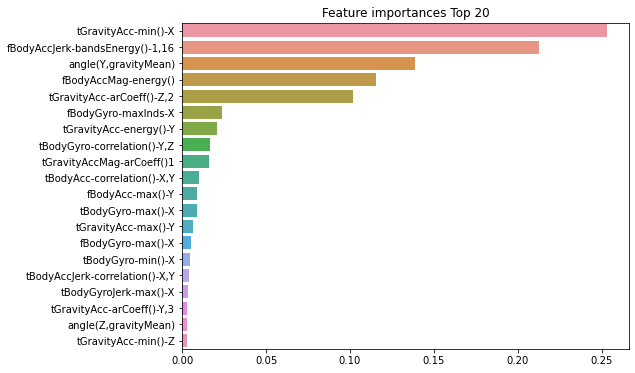

In [33]:
import seaborn as sns

ftr_importances_values = best_df_clf.feature_importances_

# Top 중요도로 정렬, seaborn 막대그래프로 표현
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)

# 중요도값 순으로 Series를 정렬
ftr_top_20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8, 6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top_20, y=ftr_top_20.index)

plt.show()

max_depth 8, min_samples_split 16일 때 테스트 데이터 세트의 정확도는 약 85.4%이며 특성 중요도는 위와 같습니다.